# Model

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F


class StackLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, bias=True, dropout=0, residual=True):
        super().__init__()
        self.input_size = input_size            # embedding_dim
        self.hidden_size = hidden_size          # rnn_dim
        self.n_layers = n_layers                # n_layers
        self.layers = nn.ModuleList()
        self.residual = residual                # 잔차연결
        self.dropout = nn.Dropout(p=dropout)    # dropout

        for i in range(n_layers):               # LSTM 층 쌓기
            self.layers.append(
                nn.LSTMCell(input_size, hidden_size, bias=bias)
            )
            input_size = hidden_size

    def forward(self, inputs, hidden):
        # input => [batch_size, rnn_dim]
        # hidden => (h_state, c_state)
        # h_state, c_state = [n_layers, batch_size, hidden_size]
        h_state, c_state = hidden  # 이전 hidden, cell 상태 받아오기

        next_h_state, next_c_state = [], []

        for i, layer in enumerate(self.layers):  # 각 층 layer와 idx
            hi = h_state[i].squeeze(dim=0)
            ci = c_state[i].squeeze(dim=0)
            # squeeze :  차원의 원소가 1인 차원을 모두 없애줌, dim=n : n번째 차원만 1이면 없애줌

            if hi.dim() == 1 and ci.dim() == 1:  # hidden, cell layer의 차원이 1이면
                hi = h_state[i]
                ci = c_state[i]

            next_hi, next_ci = layer(inputs, (hi, ci))
            output = next_hi

            if i + 1 < self.n_layers:   # rnn dropout layer
                output = self.dropout(output)
            if self.residual and inputs.size(-1) == output.size(-1):  # 잔차연결
                inputs = output + inputs
            else:
                inputs = output

            next_h_state.append(next_hi)
            next_c_state.append(next_ci)

        next_hidden = (
            torch.stack(next_h_state, dim=0),   # hidden layer concaternate
            torch.stack(next_c_state, dim=0)    # cell layer concaternate
        )
        # input => [batch_size, rnn_dim]
        # next_hidden => (h_state, c_state)
        # h_state, c_state = [n_layers, batch_size, hidden_size]
        return inputs, next_hidden

- LSTM Cell을 만들어서 쌓아올리는 함수

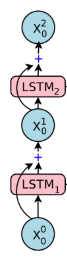

- 먼저 이전 시점의 input과 hidden layer을 받아온다.
- layer의 개수 만큼 반복문을 실행하여 hidden status와 cell status를 만들어간다
- 각 LSTM에 Dropout을 시킨다.
- 두번째 LSTM층부터 residual connection을 실시한다
- n개의 LSTM을 거치고 난 output과 hidden layer을 쌓은 tensor를 출력한다.

In [ ]:
class Recurrent(nn.Module):
    def __init__(self, cell, reverse=False):
        super().__init__()
        self.cell = cell
        self.reverse = reverse  # reverse : 양방향 시 사용

    def forward(self, inputs, hidden=None):
        # inputs => [batch_size, sequence_len, embedding_dim]
        # hidden => (h_state, c_state)
        # h_state, c_state = [n_layers, batch_size, hidden_size]
        hidden_size = self.cell.hidden_size
        batch_size = inputs.size()[0]

        if hidden is None:
            n_layers = self.cell.n_layers
            zero = inputs.data.new(1).zero_()
            # hidden 초기화
            h0 = zero.view(1, 1, 1).expand(n_layers, batch_size, hidden_size)
            # Xavier normal 초기화
            nn.init.xavier_normal_(h0)
            # cell 초기화
            c0 = zero.view(1, 1, 1).expand(n_layers, batch_size, hidden_size)
            hidden = (h0, c0)

        outputs = []
        inputs_time = inputs.split(1, dim=1)    # => ([batch_size, 1, embedding_dim] * sequence_len)
        if self.reverse:
            inputs_time = list(inputs_time)
            inputs_time.reverse()

        for input_t in inputs_time:             # sequence_len 만큼 반복
            input_t = input_t.squeeze(1)        # => [batch_size, embedding_dim]
            output_t, hidden = self.cell(input_t, hidden)
            outputs += [output_t]

        if self.reverse:
            outputs.reverse()
        outputs = torch.stack(outputs, dim=1)
        # outputs => [batch_size, sequence_len, embedding_dim]
        # hidden => (h_state, c_state)
        # h_state, c_state = [n_layers, batch_size, hidden_size]
        return outputs, hidden

- 이전 시점의 input과 hidden을 받아와서 Recurrent를 실시
- hidden layer의 경우 Xavier normal initialize를 적용
- Bidirectional LSTM을 사용하기 위해 reverse 변수 사용
    - reverse 변수 사용 시 input이 역순으로 바뀌어서 들어가게 됨
    
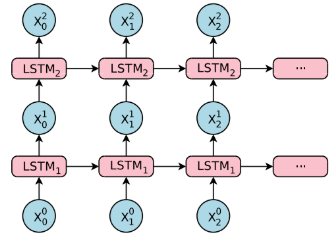
- 이미지 출처 : https://norman3.github.io/papers/docs/google_neural_machine_translation.html


In [ ]:
class BiRecurrent(nn.Module):
    def __init__(self, cell, output_transformer, output_transformer_bias,
                 hidden_transformer, hidden_transformer_bias):
        super().__init__()
        hidden_size = cell.hidden_size * 2
        self.forward_rnn = Recurrent(cell, reverse=False)
        self.reverse_rnn = Recurrent(cell, reverse=True)
        self.output_nn = nn.Linear(hidden_size, output_transformer, bias=output_transformer_bias)
        self.hidden_nn = nn.Linear(hidden_size, hidden_transformer, bias=hidden_transformer_bias)
        self.cell_nn = nn.Linear(hidden_size, hidden_transformer, bias=hidden_transformer_bias)

    def forward(self, inputs, hidden=None):
        forward_output, (forward_hidden, forward_cell) = self.forward_rnn(inputs, hidden)
        reverse_output, (reverse_hidden, reverse_cell) = self.reverse_rnn(inputs, hidden)

        output = torch.cat((forward_output, reverse_output), dim=2)
        output = self.output_nn(output)
        hidden = torch.cat((forward_hidden, reverse_hidden), dim=2)
        hidden = self.hidden_nn(hidden)
        cell = torch.cat((forward_cell, reverse_cell), dim=2)
        cell = self.cell_nn(cell)

        return output, (hidden, cell)

- Bidirectional LSTM을 만드는 함수
- forward lstm과 reverse lstm을 만들어서 concat 시킨다
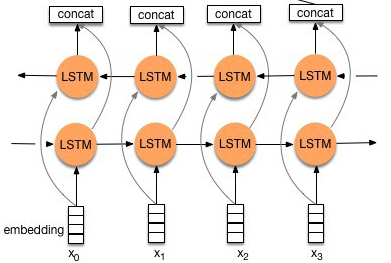
- 이미지 출처 : https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66


In [ ]:
class Encoder(nn.Module):
    def __init__(self, embedding_size, embedding_dim, rnn_dim, rnn_bias, pad_id, n_layers=1, bidirectional=True,
                 residual_used=True, embedding_dropout=0, rnn_dropout=0, dropout=0,
                 encoder_output_transformer=None, encoder_output_transformer_bias=None,
                 encoder_hidden_transformer=None, encoder_hidden_transformer_bias=None):
        super().__init__()
        self.embedding = nn.Embedding(embedding_size, embedding_dim, padding_idx=pad_id)    # Embedding Layer
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)                            # Embedding dropout
        self.dropout = nn.Dropout(p=dropout)
        self.bidirectional = bidirectional                                                  # Bidirectional LSTM

        # rnn cell
        cell = StackLSTMCell(input_size=self.embedding.embedding_dim, hidden_size=rnn_dim, n_layers=n_layers,
                             bias=rnn_bias, dropout=rnn_dropout, residual=residual_used)
        if bidirectional:
            assert encoder_output_transformer and encoder_output_transformer_bias \
                   and encoder_hidden_transformer and encoder_hidden_transformer_bias, 'not input transformer parameter'
            # 가정설정문 : parameter 중 하나라도 안들어오면 해당 메세지 출력
            self.rnn = BiRecurrent(cell, encoder_output_transformer, encoder_output_transformer_bias,
                                   encoder_hidden_transformer, encoder_hidden_transformer_bias)
        else:
            self.rnn = Recurrent(cell)

    def forward(self, enc_input):
        # enc_input => [batch_size, sequence_len]
        embedded = self.embedding_dropout(self.embedding(enc_input))    # input을 embedding시키고 dropout 적용
        # embedded => [batch_size, sequence_len, embedding_dim]
        output, (hidden, cell) = self.rnn(embedded)
        output = self.dropout(output)
        # output => [batch_size, sequence_len, rnn_dim]
        # hidden => [n_layer, batch_size, rnn_dim]
        # cell => [n_layer, batch_size, rnn_dim]
        return output, (hidden, cell)

- Seq2Seq Encoder
- 먼저 들어온 input을 embedding을 한 뒤 dropout을 적용
- embedding을 거친 input을 lstm에 적용시켜서 output, hidden, cell을 구하고 출력
- rnn은 기본 rnn과 Bidirectional Rnn을 선택할 수 있다.

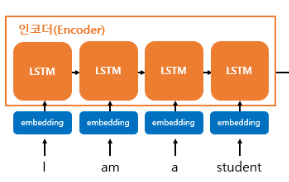
- 이미지 출처 :https://wikidocs.net/24996

In [ ]:
class Decoder(nn.Module):
    def __init__(self, embedding_size, embedding_dim, rnn_dim, rnn_bias, pad_id, n_layers=1, embedding_dropout=0,
                 rnn_dropout=0, dropout=0, residual_used=True):
        super().__init__()
        self.vocab_size = embedding_size
        self.embedding = nn.Embedding(embedding_size, embedding_dim, padding_idx=pad_id)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.dropout = nn.Dropout(p=dropout)
        self.hidden_size = rnn_dim              # beam search 적용시 사용하는 변수
        cell = StackLSTMCell(input_size=self.embedding.embedding_dim, hidden_size=rnn_dim, n_layers=n_layers,
                             bias=rnn_bias, residual=residual_used, dropout=rnn_dropout)
        self.rnn = Recurrent(cell)  # 기본 rnn
        self.classifier = nn.Linear(rnn_dim, embedding_size)    # dense

    def forward(self, dec_input, hidden):
        embedded = self.embedding_dropout(self.embedding(dec_input))    # decoder input을 embedding 후 dropout
        output, hidden = self.rnn(inputs=embedded, hidden=hidden)       
        # output => [batch_size, sequence_size, rnn_dim]
        # embedding 거치 input과 encoder에서 나온 hidden layer을 decoder lstm에 넣어줌
        output = self.dropout(output)   
        # output => [batch_size, sequence_size, rnn_dim]
        output = self.classifier(output)    # dense 라인 적용
        # output => [batch_size, sequence_size, embedding_size]
        return output, hidden

- Seq2Seq Decoder
- Encoder에서 출력된 context(hidden layer)을 받아서 input과 함께 입력값으로 받음
- embedding과 rnn을 거친 뒤 Dense를 지나감
- softmax의 경우 실시하지 않고 마지막 출력 전에 softmax를 적용시킬 예정

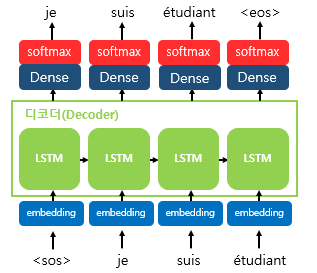
- 이미지 출처 :https://wikidocs.net/24996

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, seq_len, beam_search=False, k=1):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.seq_len = seq_len
        self.beam_search = beam_search
        self.k = k
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def forward(self, enc_input, dec_input, teacher_forcing_rate=0.5):
        # enc_input, dec_input => [batch_size, sequence_len]
        seed_val = 42
        random.seed(seed_val)
        encoder_output, pre_hidden = self.encoder(enc_input)
        # output => [batch_size, sequence_len, rnn_dim]
        # pre_hidden => (hidden, cell)
        # hidden => [n_layer, batch_size, rnn_dim]
        # cell => [n_layer, batch_size, rnn_dim]

        if self.beam_search:   # test시 beam Search 적용
            beam = Beam(self.k, pre_hidden, self.decoder, enc_input.size(0), enc_input.size(1), F.log_softmax,
                        self.device)
            dec_input_i = dec_input[:, 0].unsqueeze(dim=1)
            output = beam.search(dec_input_i, encoder_output)

        else:
            if teacher_forcing_rate == 1.0:  # 교사강요 무조건 적용  => 답을 그대로 다음 input에 넣음
                output, _ = self.decoder(dec_input=dec_input, hidden=pre_hidden)

            else:
                outputs = []
                dec_input_i = dec_input[:, 0].unsqueeze(dim=1)
                for i in range(1, self.seq_len+1):
                    output, pre_hidden = self.decoder(dec_input=dec_input_i, hidden=pre_hidden)
                    _, indices = output.max(dim=2)
                    output = output.squeeze(dim=1)
                    outputs.append(output)

                    if i != self.seq_len:
                        dec_input_i = dec_input[:, i].unsqueeze(dim=1) if random.random() < teacher_forcing_rate \
                            else indices
                output = torch.stack(outputs, dim=1)
            output = F.log_softmax(output, dim=1)  # Log Soft max를 이 시점에서 적용 후 return

        return output


- Seq2Seq Model 입니다.
- 먼저 모델 비교 시 random 값에 따라 달라질 수 있기 때문에 seed를 고정시켜줍니다.
- encoder의 input을 encoder에 넣은 뒤 출력되는 값을 encoder_output과 pre_hidden에 넣어줍니다.
- test시에는 beam_search를 적용시켜줍니다.
- 마지막에 출력 전 decoder라인에서 하지 않았던 log softmax를 적용시켜줍니다.
- Teacher Forcing은 Decoder에서 잘못된 결과가 다음단계의 input으로 들어가는 것을 막고 항상 정답을 input으로 넣는 방법입니다.
- Scheduled Sampling은 step에 지나감에 따라 Teacher Forcing할 확률을 감소시키면서 test와 비슷한 환경을 만들어서 input을 넣는 방법입니다.
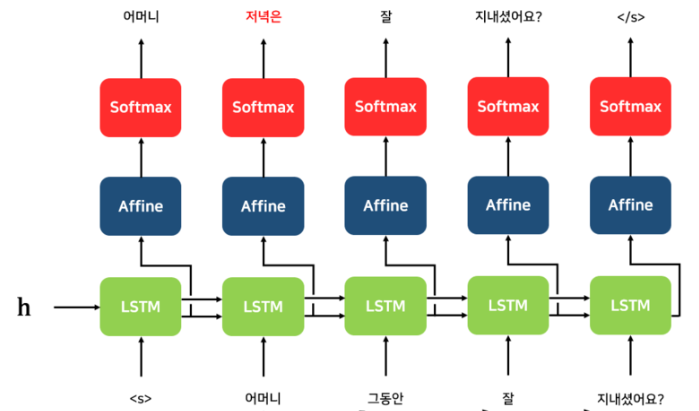
- 이미지 출처 : https://blog.naver.com/PostView.nhn?blogId=sooftware&logNo=221790750668&categoryNo=0&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView

In [ ]:
class Beam:
    r"""
    https://github.com/sh951011/Korean-Speech-Recognition/blob/baf408d14fa1beb88aa50c181630a8878d9f0ba3/models/speller.py#L112
    Applying Beam-Search during decoding process.
    Args:
        k (int) : size of beam
        decoder_hidden (torch.Tensor) : hidden state of decoder
        batch_size (int) : mini-batch size during infer
        max_len (int) :  a maximum allowed length for the sequence to be processed
        function (torch.nn.Module) : A function used to generate symbols from RNN hidden state
        (default : torch.nn.functional.log_softmax)
        decoder (torch.nn.Module) : get pointer of decoder object to get multiple parameters at once
        beams (torch.Tensor) : ongoing beams for decoding
        probs (torch.Tensor) : cumulative probability of beams (score of beams)
        sentences (list) : store beams which met <eos> token and terminated decoding process.
        sentence_probs (list) : score of sentences
    Inputs: decoder_input, encoder_outputs
        - **decoder_input** (torch.Tensor): initial input of decoder - <sos>
        - **encoder_outputs** (torch.Tensor): tensor with containing the outputs of the encoder.
    Returns: y_hats
        - **y_hats** (batch, seq_len): predicted y values (y_hat) by the model
    Examples::
        # >>> beam = Beam(k, decoder_hidden, decoder, batch_size, max_len, F.log_softmax)
        # >>> y_hats = beam.search(inputs, encoder_outputs)
    """

    def __init__(self, k, decoder_hidden, decoder, batch_size, max_len, function, device):
        assert k > 1, "beam size (k) should be bigger than 1"
        self.k = k
        self.device = device
        self.decoder_hidden = decoder_hidden
        self.batch_size = batch_size
        self.max_len = max_len
        self.function = function
        self.rnn = decoder.rnn
        self.embedding = decoder.embedding
        self.input_dropout = decoder.embedding_dropout
        self.use_attention = None
        self.attention = None
        self.hidden_size = decoder.hidden_size
        self.vocab_size = decoder.vocab_size
        self.w = nn.Linear(self.hidden_size, self.vocab_size).to(self.device)
        self.eos_id = 1
        self.beams = None
        self.probs = None
        self.sentences = [[] for _ in range(self.batch_size)]
        self.sentence_probs = [[] for _ in range(self.batch_size)]

In [ ]:
    def _get_best(self):
        """ 최종후보 k개 중에서 최고 확률이 높은 1개를 선택해서 출력 """
        y_hats = []

        for batch_num, batch in enumerate(self.sentences):
            if len(batch) == 0:
                # if there is no terminated sentences, bring ongoing sentence which has the highest probability instead
                prob_batch = self.probs[batch_num].to(self.device)
                top_beam_idx = int(prob_batch.topk(1)[1])
                y_hats.append(self.beams[batch_num, top_beam_idx])

            else:
                # bring highest probability sentence
                top_beam_idx = int(torch.FloatTensor(self.sentence_probs[batch_num]).topk(1)[1])
                y_hats.append(self.sentences[batch_num][top_beam_idx])
        y_hats = self._match_len(y_hats).to(self.device)
        return y_hats

In [ ]:
    def _match_len(self, y_hats):
        """ 만약에 y_hat이 sequence_len보다 길다면 해당 길이까지만 자르고 출력"""
        max_len = -1
        for y_hat in y_hats:
            if len(y_hat) > max_len:
                max_len = len(y_hat)

        matched = torch.LongTensor(self.batch_size, max_len).to(self.device)
        for batch_num, y_hat in enumerate(y_hats):
            matched[batch_num, :len(y_hat)] = y_hat
            matched[batch_num, len(y_hat):] = 0

        return matched

In [ ]:
    def _is_done(self):
        """ 최종후보가 k개인지 확인"""
        for done in self.sentences:
            if len(done) < self.k:
                return False
        return True

    def _forward_step(self, decoder_input, encoder_outputs):
        """ 각 셀마다 현재 상태에서 확률벡터를 구하고 출력"""
        decoder_input = decoder_input.to(self.device)
        output_size = decoder_input.size(1)
        embedded = self.embedding(decoder_input).to(self.device)
        embedded = self.input_dropout(embedded)

        if self.use_attention:
            output, hidden, _ = self.rnn(inputs=embedded, hidden=self.decoder_hidden, get_attention=True,
                                         attention=self.attention, encoder_outputs=encoder_outputs)  # decoder output
        else:
            output, hidden = self.rnn(inputs=embedded, hidden=self.decoder_hidden)  # decoder output
        predicted_softmax = self.function(self.w(output.contiguous().view(-1, self.hidden_size)), dim=1).to(self.device)
        predicted_softmax = predicted_softmax.view(self.batch_size, output_size, -1)
        return predicted_softmax

In [ ]:
    def _replace_beam(self, child_ps, child_vs, done_ids, count):
        """ 만약에 end token이 나왔다면 그것을 최종후보에 등록시키고, k+1번째로 다시 전개시켜 k개로 맞춤"""
        done_batch_num, done_beam_idx = done_ids[0], done_ids[1]
        tmp_ids = child_ps.topk(self.k + count)[1]
        new_child_idx = tmp_ids[done_batch_num, -1]
        new_child_p = child_ps[done_batch_num, new_child_idx].to(self.device)
        new_child_v = child_vs[done_batch_num, new_child_idx].to(self.device)
        parent_beam_idx = (new_child_idx // self.k)
        parent_beam = self.beams[done_batch_num, parent_beam_idx].to(self.device)
        parent_beam = parent_beam[:-1]
        new_beam = torch.cat([parent_beam, new_child_v.view(1)])
        self.beams[done_batch_num, done_beam_idx] = new_beam
        self.probs[done_batch_num, done_beam_idx] = new_child_p
    def _get_length_penalty(self, length, alpha=1.2, min_length=5):
        """ 확률은 0~1 사이이므로 길이가 길어질 수록 더 적아진다. 이를 보완하기 위해 길이에 따른 패널티를 부여하고 계산하며,
        일반적으로 alpha = 1.2, min_length = 5를 사용하며, 이는 수정가능하다."""
        return ((min_length + length) / (min_length + 1)) ** alpha

- 어떤 빔이 end token을 만나게 되면 해당 빔을 최종 후보에 오르게 된다.
- 최종 후보에 오른 빔으로 인해 현 시점의 빔은 k-1개가 되고, 한 자리를 보충하기 위해 k+1번째 였던 빔을 포함시킨다.
- ( 어떤 시점에서 x개의 빔이 end token을 만나서 종료된다면, 상위 K+1위 ~ K+x위의 빔이 활성화된다 )
<br><br>
- Length Penalty: 길이가 길어짐으로 인해 발생하는 불공평성을 해결해주는 것
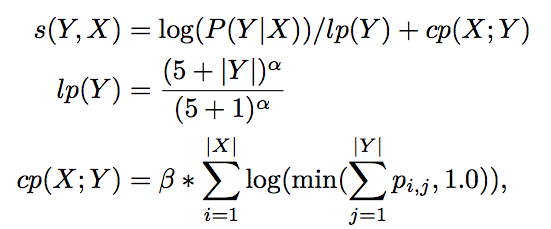
https://blog.naver.com/sooftware/221809101199

In [ ]:
    def search(self, decoder_input, encoder_outputs):
        # decoder_input => [batch_size, 1]
        # encoder_outputs => [ batch_size, seq_len, hidden_size]

        # get class classfication distribution => [batch_size, vocab_size]
        step_outputs = self._forward_step(decoder_input, encoder_outputs).squeeze(1)

        # get top K probability & idx => probs =[batch_size, k], beams = [batch_size, k]
        # 상위 k개 뽑기
        self.probs, self.beams = step_outputs.topk(self.k)
        decoder_input = self.beams
        # transpose => [batch_size, k, 1]
        self.beams = self.beams.view(self.batch_size, self.k, 1)
        for di in range(self.max_len - 1):
            if self._is_done():
                break
            # For each beam, get class classfication distribution (shape: BxKxC)
            # 현재 시점에서 확률벡터를 구함
            predicted_softmax = self._forward_step(decoder_input, encoder_outputs)
            step_output = predicted_softmax.squeeze(1)
            # get top k distribution (shape: BxKxK)
            # 현재 확률벡터 기준으로 상위벡터 k개를 구함
            child_ps, child_vs = step_output.topk(self.k)
            # get child probability (applying length penalty)
            # length penalty
            child_ps = self.probs.view(self.batch_size, 1, self.k) + child_ps
            child_ps /= self._get_length_penalty(length=di + 1, alpha=1.2, min_length=5)
            # Transpose (BxKxK) => (BxK^2)
            child_ps = child_ps.view(self.batch_size, self.k * self.k)
            child_vs = child_vs.view(self.batch_size, self.k * self.k)
            # Select Top k in K^2 (shape: BxK)
            topk_child_ps, topk_child_ids = child_ps.topk(self.k)
            # Initiate topk_child_vs (shape: BxK)
            topk_child_vs = torch.LongTensor(self.batch_size, self.k)
            # Initiate parent_beams (shape: BxKxS)
            parent_beams = torch.LongTensor(self.beams.size())
            # ids // k => ids of topk_child`s parent node
            parent_beams_ids = (topk_child_ids // self.k).view(self.batch_size, self.k)

            for batch_num, batch in enumerate(topk_child_ids):
                for beam_idx, topk_child_idx in enumerate(batch):
                    topk_child_vs[batch_num, beam_idx] = child_vs[batch_num, topk_child_idx]
                    parent_beams[batch_num, beam_idx] = self.beams[batch_num, parent_beams_ids[batch_num, beam_idx]]
            # append new_topk_child (shape: BxKx(S) => BxKx(S+1))
            self.beams = torch.cat([parent_beams, topk_child_vs.view(self.batch_size, self.k, 1)], dim=2)
            self.probs = topk_child_ps

            if torch.any(topk_child_vs == self.eos_id):
                done_ids = torch.where(topk_child_vs == self.eos_id)    # eos id 가 나오면 done_ids에 저장
                count = [1] * self.batch_size                           # count done beams
                for (batch_num, beam_idx) in zip(*done_ids):
                    self.sentences[batch_num].append(self.beams[batch_num, beam_idx])
                    self.sentence_probs[batch_num].append(self.probs[batch_num, beam_idx])
                    self._replace_beam(
                        child_ps=child_ps,
                        child_vs=child_vs,
                        done_ids=(batch_num, beam_idx),
                        count=count[batch_num]
                    )
                    count[batch_num] += 1
            # update decoder_input by topk_child_vs
            decoder_input = topk_child_vs
        y_hats = self._get_best()
        return y_hats